# Análise da quantidade de itens de um projeto cultural
---

**Objetivo:** realizar uma análise comparativa entre a quantidade de itens de um projeto cultural específico com a quantidade de itens dos outros projetos culturais de um mesmo segmento. Nesta análise, será investigado se a quantidade de itens de um projeto é anormal com relação a quantidade de itens dos outros projetos do mesmo segmento.

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df.columns)
df.head()

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto,cdCidade,cdEtapa
0,121051,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,Unidade,150,40.0,1.0,150.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
1,121051,100855,792883,Bonecos – Criação,3599,Verba,90,1.0,1.0,4000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
2,121051,100855,792903,Produtor executivo,53,Verba,90,3.0,1.0,3000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,355030,2
3,119968,98671,109095,Assistente de produção,1037,Verba,30,1.0,1.0,1000.0,...,1 - Pré-Produção / Preparação,3,Música,31,Música Popular Cantada,51,Apresentação Musical,2009-12-28 11:37:57.830,330455,1
4,112836,91695,116511,Designer,103,Mês,378,1.0,18.0,2000.0,...,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,17,Pesquisa,2009-05-21 10:48:48.790,431490,2


#### Gerando tabela com o número itens por projeto por segmento

In [3]:
num_items = df[['PRONAC', 'idSegmento', 'idPlanilhaAprovacao']].drop_duplicates()
num_items = num_items.groupby(['idSegmento', 'PRONAC']).count()
num_items = num_items.rename(columns={'idPlanilhaAprovacao': 'NumItems'})
num_items.head()

NumItems
idSegmento PRONAC          
11         90105         61
           97310         32
           98022         17
           100855        96
           102857        61

## Análise por segmento
---

Nesta etapa, analisaremos a quantidade de itens dos projetos para um segmento escolhido.

#### Esolhendo um segmento e gerando uma lista do número de itens para todos os projetos do segmento

In [4]:
segment = '11'
segment_projects = num_items.loc[segment]['NumItems']

#### Gerando gráfico dos dados acima

Média da distribuição: 54.64
Desvio padrão da distribuição: 40.49



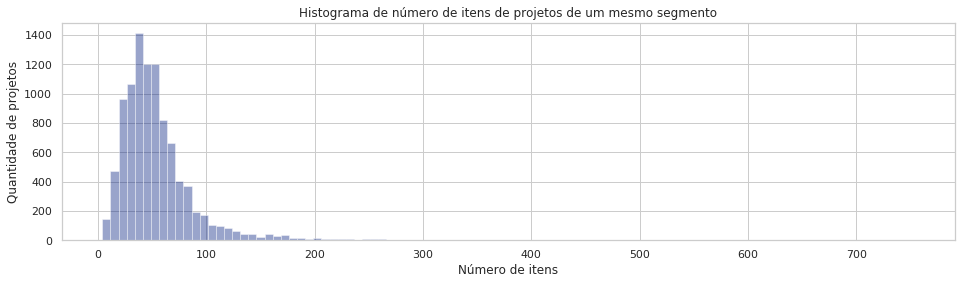

In [5]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(segment_projects, bins=100, kde=False)
plt.title('Histograma de número de itens de projetos de um mesmo segmento')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Número de itens')
plt.grid(True)

expected_mean = np.mean(segment_projects)
expected_std = np.std(segment_projects)
print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [6]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
126804      57
1010651     54
149001      77
155589      49
121386     107
Name: NumItems, dtype: int64

PRONAC
1511215    70
171568     30
161187     59
132949     77
148156     56
Name: NumItems, dtype: int64

### Análise Gaussiana

In [7]:
class Gaussian:
    def __init__(self, contamination=0.1):
        '''Outlier Detection by fitting data in a Gaussian model.

        Fit a Gaussian function on the training set and find the lower and upper
        limits for a sample to be considered an inlier. The limits are computed
        by translating the contamination value into a point in the Gaussian model.
        
        If the sample is farther from the average than the limits, it's considered
        an outlier. Otherwise it's an inlier.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination

    def fit(self, X):
        '''Fit the Gaussian model, i.e. compute mean and standard deviation of X,
        using X as training data.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to Gaussian.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the Gaussian Estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        lower = self.model.ppf(0.5*self.contamination)
        upper = self.model.ppf(1 - 0.5*self.contamination)
        is_inlier = ((X >= lower) & (X <= upper))
        return is_inlier

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.56 ms
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 3.98%


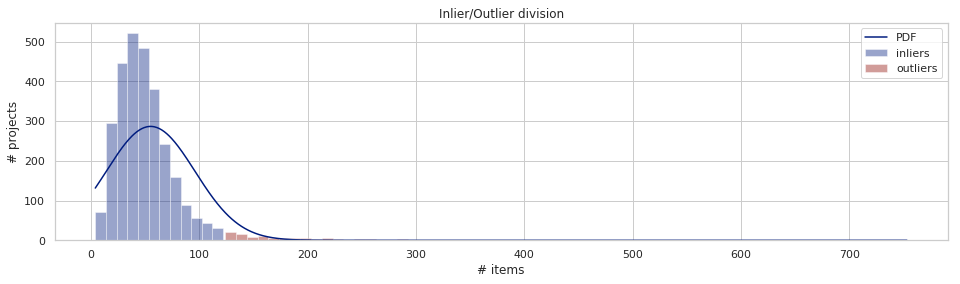

In [8]:
model = Gaussian()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 10
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

x = np.linspace(min(segment_projects), max(segment_projects), 1000)
plt.plot(x,  bin_size * len(projects_test) * model.model.pdf(x), label='PDF')

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('# items')
plt.title('Inlier/Outlier division');

### Análise Log-normal

In [9]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=None):
        '''Outlier Detection by fitting data in a Log-normal model.

        Fit a Log-normal function on the training set and find the upper limit for
        a sample to be considered an inlier. The limit is computed by translating
        the contamination value into a point in the Log-normal model.
        
        If the sample is greater than the upper limit, it's considered an outlier,
        otherwise, it's an inlier.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        '''Fit the Log-normal model, i.e. compute the standard deviation of X,
        using X as training data.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        if self.transform:
            X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to
        the Log-normal model.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the Log-normal Estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        if self.transform:
            X = self.transform(X)
        upper = self.model.ppf(1 - self.contamination)
        is_inlier = (X <= upper)
        return is_inlier

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.98 ms
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.22%


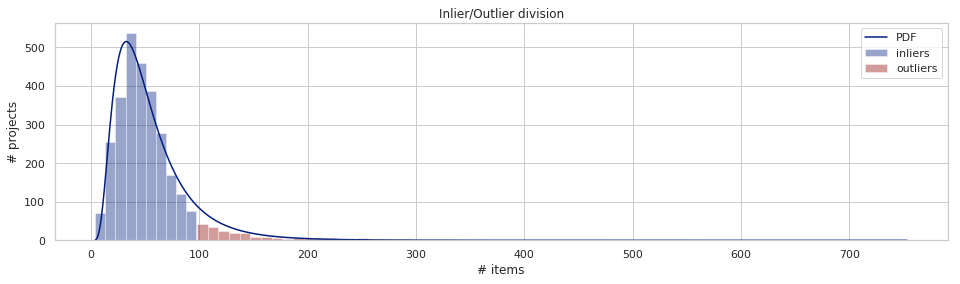

In [10]:
model = Lognormal()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 10
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

x = np.linspace(min(segment_projects), max(segment_projects), 1000)
plt.plot(x,  bin_size * len(projects_test) * model.model.pdf(x), label='PDF')

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('# items')
plt.title('Inlier/Outlier division');

### Análise Gamma

In [11]:
class Gamma:
    def __init__(self, contamination=0.1, transform=None):
        '''Outlier Detection by fitting data in a Gamma model.

        Fit a Gamma function on the training set and find the upper and lower limits
        for a sample to be considered an inlier. The limits are computed by translating
        the contamination value into points in the Gamma model.
        
        If the sample is greater than the upper limit or lower than the lower limit,
        it's considered an outlier, otherwise, it's an inlier.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        '''Fit the Gamma model, i.e. compute its parameters, using X as training data.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to
        the Gamma model.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the Log-normal Estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        lower = self.model.ppf(0.5*self.contamination)
        upper = self.model.ppf(1 - 0.5*self.contamination)
        is_inlier = ((X >= lower) & (X <= upper))
        return is_inlier

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 11.2 ms
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.86%


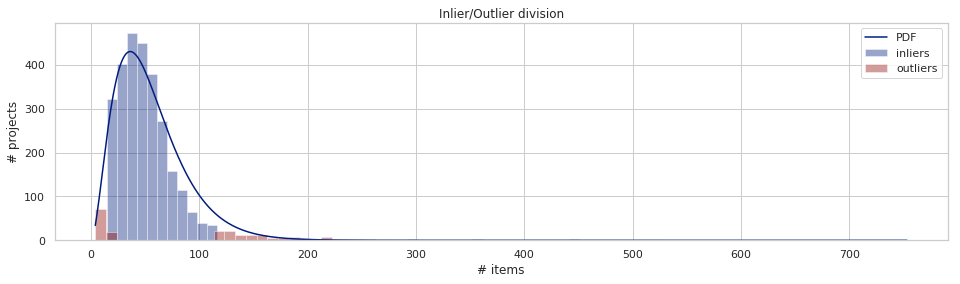

In [12]:
model = Gamma()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 10
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

x = np.linspace(min(segment_projects), max(segment_projects), 1000)
plt.plot(x,  bin_size * len(projects_test) * model.model.pdf(x), label='PDF')

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('# items')
plt.title('Inlier/Outlier division');

### Análise LOF

In [13]:
from sklearn.neighbors import LocalOutlierFactor

class LOF:
    def __init__(self, contamination=0.1):
        '''Unsupervised Outlier Detection by fitting data in a Local Outlier Factor
        model.

        The class sklearn.neighbors.LocalOutlierFactor has two operation modes:
            1. Outlier Detection: given a set of samples, return which samples are
               inliers and which ones are outliers.
            2. Novelty Detection: train model with inliers and predict if a new
               sample is inlier or outlier.
        
        This class uses the "Outlier Detection" to separate inliers and outliers
        from the training data, and then uses the "Novelty Detection" to train the
        model itself. At the prediction, the "Novelty Detection" separates the
        inliers and outliers.

        Parameters
        ----------
        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, i.e. the proportion
            of outliers in the data set. When fitting this is used to define the
            threshold on the decision function.
        '''
        self.contamination = contamination

    def fit(self, X):
        '''Fit the LOF model, i.e. use the "Outlier Detection" to separate inliers
        and outliers from the training data and then uses the "Novelty Detection"
        to train the model itself.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training data.

        Returns
        -------
        self : object
        '''
        # Transform data into a 2D array
        X = self._1Dto2D(X)

        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]

        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=0.5)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        '''Predict the labels (True inlier, False outlier) of X according to
        the Local Outlier Factor model.

        This method allows to generalize prediction to *new observations* (not
        in the training set).

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            The query sample or samples to compute the LOF estimation
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns False for anomalies/outliers and True for inliers.
        '''
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        '''Given a pd.Series, return a "2D" np.Array with zeros in one dimension.
        
        Parameters
        ----------
        X : pd.Series, shape (n_samples,)
        
        Returns
        -------
        X : bidimensional ndarray, shape (n_samples, 2)
        '''
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 37.9 ms
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 5.11%


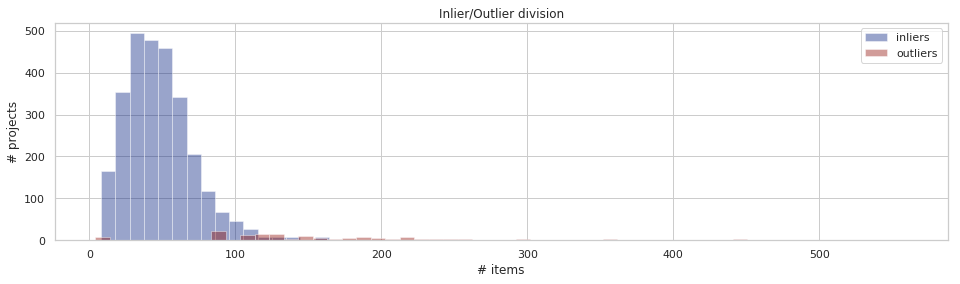

In [14]:
model = LOF()
model.fit(projects_train)
%time inlier_filter = model.predict(projects_test)

contamination_found = sum(~inlier_filter) / len(projects_test)
print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 10
inliers = projects_test[inlier_filter].values
bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

outliers = projects_test[~inlier_filter].values
bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)

plt.legend(frameon=True)
plt.ylabel('# projects')
plt.xlabel('# items')
plt.title('Inlier/Outlier division');

### Avaliando a contaminação para cada um dos métodos

Nesta seção, os diversos modelos implementados são aplicados a 100 escolhas diferentes de conjuntos de treino/teste. Ao final, o desempenho de cada método é avaliado.

In [15]:
percentuals = {
    'gauss': [],
    'lognorm': [],
    'gamma': [],
    'lof': []
}

gauss = Gaussian()
lognorm = Lognormal()
gamma = Gamma()
lof = LOF()

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)
    
    # GAUSSIAN
    inlier_filter = (gauss.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['gauss'].append(100 * contamination_found)
    
    # LOGNORMAL
    inlier_filter = (lognorm.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['lognorm'].append(100 * contamination_found)
    
    # GAMMA
    inlier_filter = (gamma.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['gamma'].append(100 * contamination_found)
    
    # LOF
    inlier_filter = (lof.fit(projects_train).predict(projects_test))
    contamination_found = sum(~inlier_filter) / len(projects_test)
    percentuals['lof'].append(100 * contamination_found)

Média gauss: 4.73%
Média lognorm: 8.37%
Média gamma: 8.41%
Média lof: 5.98%


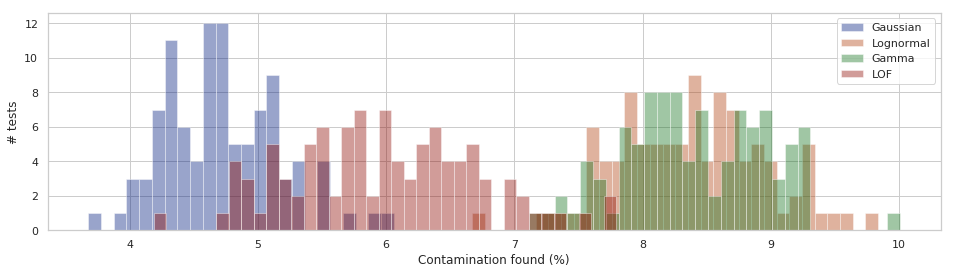

In [16]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.1
results = percentuals['gauss']
print('Média gauss: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='Gaussian', kde=False, bins=bins)

results = percentuals['lognorm']
print('Média lognorm: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='Lognormal', kde=False, bins=bins)

results = percentuals['gamma']
print('Média gamma: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='Gamma', kde=False, bins=bins)

results = percentuals['lof']
print('Média lof: %.2lf%%' % np.mean(results))
bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
sns.distplot(results, label='LOF', kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

#### Conclusões

O dataset para o segmento 11 tem uma distribuição bem próxima à distribuição Log-normal, contudo a distribuição Gamma ainda apresentou os melhores resultados. Mesmo com um dataset com distribuição próxima a uma Gaussiana, o percentual de contaminação encontrado pelo LOF se mostrou mais próximo do valor esperado que a estimação de contaminação encontrada pelo modelo Gaussiano.

Outro ponto importante a se notar é a marcação de projetos como inlier/outlier em ambos os estimadores. Na estimação Gaussiana, os projetos são marcados como outliers apenas se a quantidade de itens deste projeto está fora de um intervalo de valores aceitáveis. Na estimação Log-normal, os projetos são marcados como outliers apenas se a quantidade de itens deste projeto for maior que um limite definido. Já no estimador LOF, se um projeto tem uma quantidade específica de itens que é relativamente menos comum que seus vizinhos (projetos com uma quantidade parecida de itens), então o projeto pode ser marcado como outlier, o que não parece fazer sentido neste contexto.

Exemplo: suponha que exista um único projeto com 100 itens, porém, vários com 99 e com 101. Utilizando o estimador LOF, este projeto poderá ser marcado como outlier.